In [23]:
# Parameters to set to run this notebook

# Initialize helpers.
import numpy as np
import project_path
from model.data_accessor import get_data_file_abs_path
from model.neuron_metadata import *
neuron_metadata_collection = NeuronMetadataCollection.load_from_chem_json(get_data_file_abs_path('chem.json'))
N = neuron_metadata_collection.get_size()

# How many seconds to run each step for. This should be long enough for stability to be observed.
step_duration_s = 2
# The step amplitudes in nA. Each amplitude will be run for step_duration
peak = 2.0
amp_delta = 1.0
step_amplitudes_nA = np.concatenate((np.arange(0, peak, amp_delta), \
                                     np.arange(peak, -amp_delta/2, -amp_delta)), axis=None) 

# Initial condition
# If you want a fixed-seed initial condition, uncomment the line below.
# np.random.seed(0)
init_conds = 10**(-4)*np.random.normal(0, 0.94, 2*N)

In [24]:
from model.neural_model import NeuralModel
from util.plot_util import *

neurons_to_observe = NeuronMetadataCollection.create_lr_names_from_base([
  "AWA",
  "AIY",
  "RIM"
])
model = NeuralModel(neuron_metadata_collection)
model.init_conds = init_conds

# Set I_inj_i(t)
awal_index = neuron_metadata_collection.get_id_from_name("AWAL")
awar_index = neuron_metadata_collection.get_id_from_name("AWAR")

def time_to_I_ext_fun(t):
  amp = step_amplitudes_nA[int(t / step_duration_s)]
  cur_I_ext = np.zeros(N)
  cur_I_ext[awal_index] = amp
  cur_I_ext[awar_index] = amp
  return cur_I_ext

# These are timesteps when I_ext changes
num_step_values = len(step_amplitudes_nA)
t_changes_I_ext = np.array(range(num_step_values)) * step_duration_s
t_changes_I_ext = t_changes_I_ext.tolist()
model.set_I_ext(time_to_I_ext_fun, t_changes_I_ext)

model.init_kunert_2017()

step_duration_timesteps = int(step_duration_s / model.dt)
simul_timesteps = step_duration_timesteps * len(step_amplitudes_nA)
(v_mat, s_mat, v_normalized_mat) = model.run(simul_timesteps)

# The oscillatory dynamic doesn't stabilize until about dt*300 onwards.
# Also, interactome analysis is done after the first 50 timesteps.
truncated_potentials = v_normalized_mat[:,:]

Timestep 0 out of 1000
Timestep 100 out of 1000
Timestep 200 out of 1000
Timestep 300 out of 1000
Timestep 400 out of 1000
Timestep 500 out of 1000
Timestep 600 out of 1000
Timestep 700 out of 1000
Timestep 800 out of 1000
Timestep 900 out of 1000
Total runtime = 3.05s


# Plot stimulus

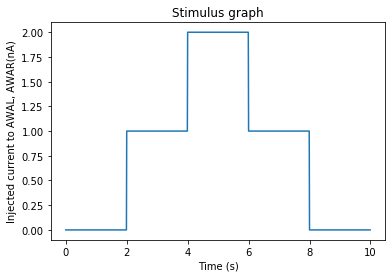

In [35]:
times = np.array(np.arange(0, simul_timesteps * model.dt, model.dt))
amps = [time_to_I_ext_fun(time)[awal_index] for time in times]
fig, ax = plt.subplots(nrows=1, ncols=1)
ax.plot(times, amps)
ax.set_title("Stimulus graph")
ax.set_ylabel("Injected current to AWAL, AWAR(nA)")
ax.set_xlabel("Time (s)")
_ = _

# Plot potentials of selected neurons

/home/stephen/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  


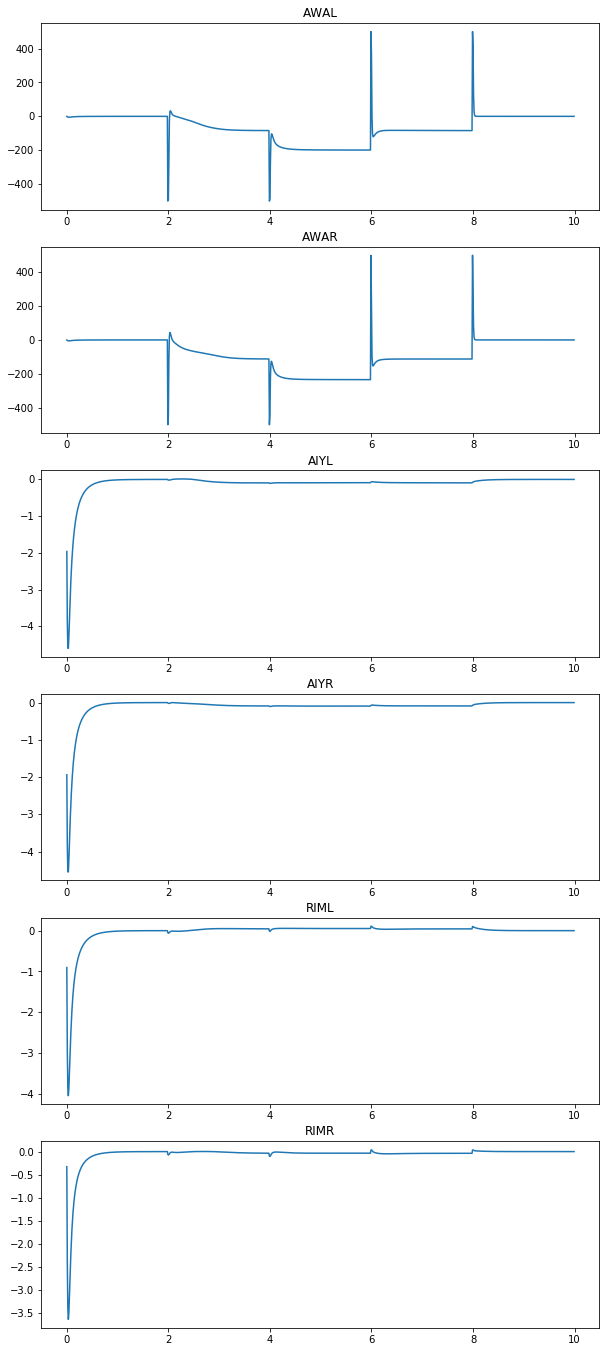

In [25]:
fig = plot_potentials(neurons_to_observe, truncated_potentials, model.dt, neuron_metadata_collection)
fig.show()

# Plot summarized dynamics per neuron class

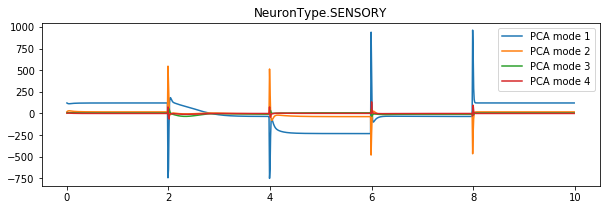

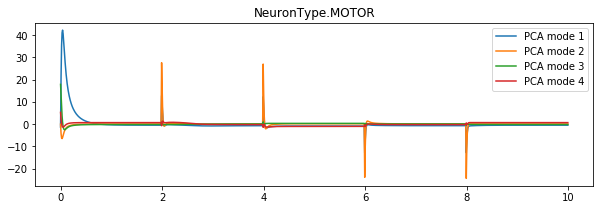

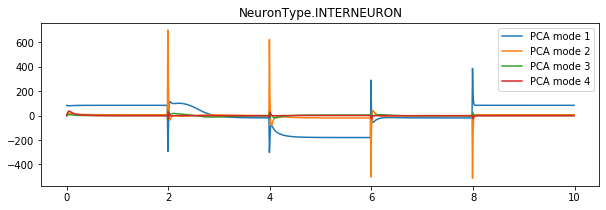

In [26]:
plot_pcas(truncated_potentials, model.dt, neuron_metadata_collection)

# Bifurcation plot

In [27]:
import util.numpy_util as np_util

# From neuron name to a list of summary statistics of one step of one neuron.
# Each array element is (prev_I, now_I, minV, maxV, meanV)
step_results_per_neuron = {}

for step_amp_i in range(len(step_amplitudes_nA)):
  prev_step_amp_nA = None
  if step_amp_i > 0:
    prev_step_amp_nA = step_amplitudes_nA[step_amp_i-1]
  step_amp_nA = step_amplitudes_nA[step_amp_i]
  timestep_start = int(step_amp_i * step_duration_s / model.dt)
  timestep_end = step_duration_timesteps + timestep_start - 1
  timestep_stable = int(timestep_end - step_duration_timesteps * 0.2)
  stable_traces_for_step = v_normalized_mat[timestep_stable:timestep_end,:]
  for neuron in neurons_to_observe:
    neuron_id = neuron_metadata_collection.get_id_from_name(neuron)
    stable_traces_for_neuron = stable_traces_for_step[:, neuron_id]
    minV = min(stable_traces_for_neuron)
    maxV = max(stable_traces_for_neuron)
    meanV = np.mean(stable_traces_for_neuron)
    
    if neuron not in step_results_per_neuron:
      step_results_per_neuron[neuron] = []
    step_results_per_neuron[neuron].append((prev_step_amp_nA, step_amp_nA, minV, maxV, meanV))

# Ascending unique current amplitudes in Na
current_Nas = np.sort(np.unique(step_amplitudes_nA))
# Key = neuron, value = list of statistics, aligned to current_Nas
minVs_per_neuron_asc = {}
maxVs_per_neuron_asc = {}
meanVs_per_neuron_asc = {}
minVs_per_neuron_desc = {}
maxVs_per_neuron_desc = {}
meanVs_per_neuron_desc = {}

for neuron in neurons_to_observe:
  for neuron_to_stats in [minVs_per_neuron_asc, maxVs_per_neuron_asc, meanVs_per_neuron_asc, \
                         minVs_per_neuron_desc, maxVs_per_neuron_desc, meanVs_per_neuron_desc]:
    neuron_to_stats[neuron] = [None] * len(current_Nas)

for neuron in neurons_to_observe:
  # Each array element is (prev_I, now_I, minV, maxV, avgV)
  step_results = step_results_per_neuron[neuron]
  for (prev_I, now_I, minV, maxV, meanV) in step_results:
    min_Vs = minVs_per_neuron_desc[neuron]
    max_Vs = maxVs_per_neuron_desc[neuron]
    mean_Vs = meanVs_per_neuron_desc[neuron]
    if prev_I is None or now_I > prev_I:
      # Ascending case.
      min_Vs = minVs_per_neuron_asc[neuron]
      max_Vs = maxVs_per_neuron_asc[neuron]
      mean_Vs = meanVs_per_neuron_asc[neuron]
    current_Na_aligned_i = np_util.find_nearest_idx(current_Nas, now_I)
    min_Vs[current_Na_aligned_i] = minV
    max_Vs[current_Na_aligned_i] = maxV
    mean_Vs[current_Na_aligned_i] = meanV
  

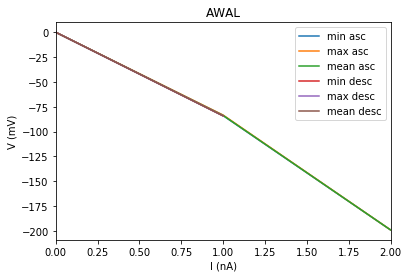

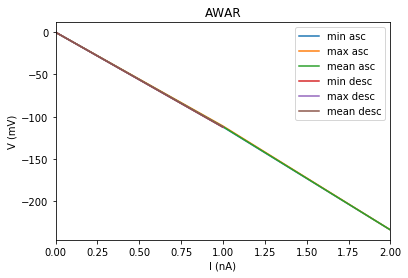

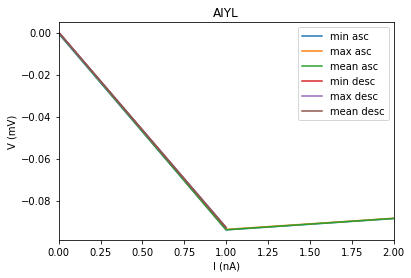

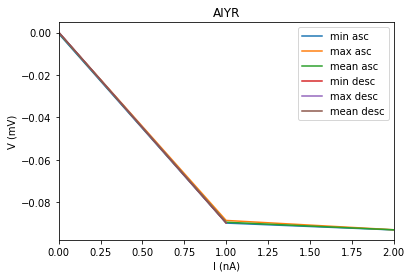

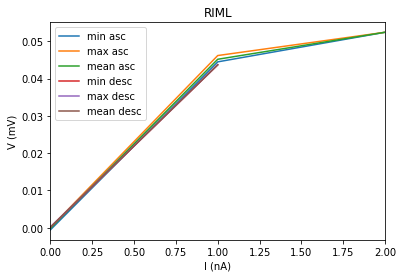

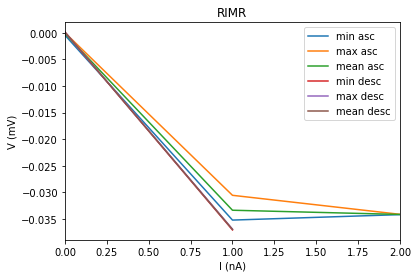

In [28]:
# Plot the summary statistics per neuron
for neuron in neurons_to_observe:
  minVs_per_neuron_asc[neuron]
  maxVs_per_neuron_asc[neuron]
  meanVs_per_neuron_asc[neuron]
  
  fig, ax = plt.subplots(nrows=1, ncols=1)
  ax.plot(current_Nas, minVs_per_neuron_asc[neuron], label="min asc")
  ax.plot(current_Nas, maxVs_per_neuron_asc[neuron], label="max asc")
  ax.plot(current_Nas, meanVs_per_neuron_asc[neuron], label="mean asc")
  ax.plot(current_Nas, minVs_per_neuron_desc[neuron], label="min desc")
  ax.plot(current_Nas, maxVs_per_neuron_desc[neuron], label="max desc")
  ax.plot(current_Nas, meanVs_per_neuron_desc[neuron], label="mean desc")
  ax.set_title("%s" % neuron)
  ax.legend()
  ax.set_xlim(min(current_Nas), max(current_Nas))
  ax.set_ylabel("V (mV)")
  ax.set_xlabel("I (nA)")